In [117]:
import tensorflow.keras
import tensorflow as tf
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *

In [118]:
train_dir = "/Users/okanbagriacik/Desktop/archive_7/Training/"
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)
# show an example of the list
print(train_paths[0])

/Users/okanbagriacik/Desktop/archive_7/Training/glioma/Tr-gl_0327.jpg


In [119]:
test_dir = "/Users/okanbagriacik/Desktop/archive_7/Testing/"
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)
# show an example of the list
print(test_paths[0])

/Users/okanbagriacik/Desktop/archive_7/Testing/notumor/Te-no_0086.jpg


In [120]:
labels = os.listdir(train_dir)
labels

['pituitary', 'notumor', 'glioma', 'meningioma']

In [121]:
def open_images(paths):
   
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

In [122]:
def get_labels(paths):
    
    
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

notumor


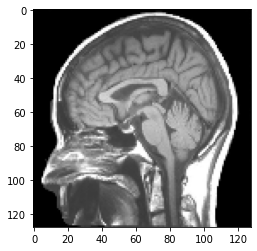

In [124]:
i = random.randint(0,len(train_paths))
label = train_paths[i].split('/')[-2] # This is how we get the label from the path train_paths[i]
image = open_images([train_paths[i]])
print(label)
plt.imshow(image[0])
plt.show()

In [125]:
def data_gen(data_paths, batch_size=10):
   
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        labels = get_labels(paths)
        yield images,np.array(labels)

In [126]:
vgg16 = VGG16(weights='/Users/okanbagriacik/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=(128,128,3), include_top=False)
# Set all layers to non-trainable
for layer in vgg16.layers:
    layer.trainable = False
# Set the last vgg block to trainable
vgg16.layers[-2].trainable = True
vgg16.layers[-3].trainable = True
vgg16.layers[-4].trainable = True

In [127]:
model = Sequential()
model.add(Input(shape=(128,128,3)))
model.add(vgg16)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) 

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [128]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [133]:
batch_size=20
model.fit(data_gen(train_paths), epochs=1, steps_per_epoch=int(len(train_paths)/batch_size))

285/285 [==============================] - 93s 327ms/step - loss: 0.2018 - sparse_categorical_accuracy: 0.9228


In [140]:
batch_size=20
model.evaluate(data_gen(test_paths), steps=int(len(test_paths)/batch_size))

65/65 [==============================] - 14s 214ms/step - loss: 0.5426 - sparse_categorical_accuracy: 0.8200


[0.5426011681556702, 0.8199999928474426]

Predicted: glioma
Actual: glioma


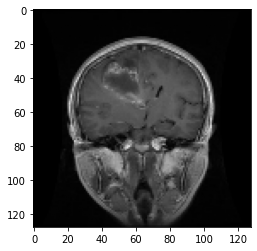

In [146]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)

In [80]:
model.save("model.hdf5")